## Analytics for Unstructured Data: Group Assignment #1

| **S.no** 	|    **Team Member**    	|
|:--------:	|:---------------------:	|
|     1    	|Amrit Pradhan|
|     2    	|Deeksha Pandit|
|     3    	|Meghna Pudupakkam Mukesh|
|     4    	|Sanjo Shaju|
|     5    	|Shivangi Dubey|

In [179]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
import re
%matplotlib inline
%pylab inline

import nltk
from nltk.tokenize import word_tokenize

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Scrapping Edmunds.com ###

Add the following checks when scrapping comments:
* __Check 1__: removing comments which are less than 100 characters. Reason: Our intuition is that if comment is less than 100 char then it might not be that useful. Example: comments like "I agree with you" etc
* __Check 2__: Scrape only comments from members, skip ones which are by Moderators.
* __Check 3__: Keep comments only from users that have posted more than 5 posts. Reason: Our intuition is that if a user is quite new to the platform he/she might not post the content in the required format and those might not be that useful.

In [117]:
# Scrapping the data from Edmunds.com using selenium
# Following scrapper will scrape 5000 comments and ignore comments based on the above mentioned checks

from selenium import webdriver
from selenium.webdriver.common.by import By
chrome_options = webdriver.ChromeOptions()

DRIVER_PATH = './chromedriver'
driver = webdriver.Chrome(DRIVER_PATH,options=chrome_options)
url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1"
driver.get(url)

df = pd.DataFrame(columns = ['Date', 'UserName', 'UserType', 'UserPostCount','Text']) 

page_count = 1
while len(df) <= 5000: # Collect 5000 comments
    # print("Scrapping page: " + str(page_count))
    user_message = driver.find_elements(By.CLASS_NAME,'Comment')

    for i in user_message:
        comment = i.find_element(By.CLASS_NAME,'Message.userContent').text

        # Check 1: removing comments which are less than 100 characters. Reason: My intuition is that if comment is less than 100 char then it might not be that useful. Example: comments like "I agree with you" etc
        if len(comment) < 100: 
            continue

        user_name = i.find_element(By.CLASS_NAME,'Author').text
        user_type = i.find_element(By.CLASS_NAME, 'AuthorInfo').find_element(By.CLASS_NAME, 'MItem.RoleTitle').text

        # Check 2: Scrape only comments from members, skip ones which are by Moderators.
        if user_type == 'Member': 
            pass
        else:
            continue

        user_posts = i.find_element(By.CLASS_NAME, 'AuthorInfo').find_element(By.CLASS_NAME, 'MItem.PostCount').text
        user_posts = user_posts.replace('Posts: ', '').replace(',', '')

        # Check 3: Keep comments only from users that have posted more than 5 posts. Reason: My intuition is that if a user is quite new to the platform he/she might not post the content in the required format and those might not be that useful.
        if int(user_posts) < 5:
            continue

        date = i.find_element(By.TAG_NAME,'time').text
        df.loc[len(df.index)] = [date, user_name, user_type, user_posts, comment]

    button = driver.find_element("link text", "»") # replicates the action of clicking the "next" button
    button.click()
    page_count += 1
    
df

/var/folders/xd/8g2mv22d6h511dx9w5j2lfs80000gn/T/ipykernel_49640/789405984.py:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(DRIVER_PATH,options=chrome_options)


,Date,UserName,UserType,UserPostCount,Text
0,March 2002,merc1,Member,6081,I personally think that with a few tweaks the ...
1,March 2002,fredvh,Member,857,I am debating a new purchase and these two are...
2,March 2002,hungrywhale,Member,83,And no manual tranny. That may not matter to y...
3,March 2002,riez,Member,2361,One beauty of BMW 3 Series is that there are s...
4,March 2002,blueguydotcom,Member,6249,"good grief, so you wait 9 months for the manua..."
...,...,...,...,...,...
519,January 2004,chrisboth,Member,493,"""Correct, with mods ala M""\n\nWhat? The mods a..."
520,January 2004,biggie2,Member,45,Why is everyone so worried about if the G is a...
521,January 2004,kdshapiro,Member,5751,chris -\n\n1. It aint anything till it's sold ...
522,January 2004,chrisboth,Member,493,whatever comp you want KD I'll feel pretty goo...


In [121]:
# Storing the scrapped data for rest of the code.
# Stored in "Comments.csv"
df.to_csv('Comments.csv', index=False)


Run the code from here incase we don't want to run the scrapper

### Data preprocessing ###

In [180]:
# Reading data from the scrapped content

df = pd.read_csv('Comments.csv')
df = df.drop(columns = ['UserName','UserType','UserPostCount'])
df.dropna(inplace = True)

# Remove puntuations, convert all to lowercase and replacing newline with space
df['Text'] = df['Text'].map(lambda x: re.sub(r'[^\w\s]', '', x.lower().replace("\n", " ")))
df[:10]

,Date,Text
0,March 2002,i personally think that with a few tweaks the ...
1,March 2002,i am debating a new volkswagen purchase and th...
2,March 2002,and no manual tranny that may not matter to yo...
3,March 2002,one beauty of bmw 3 series is that there are s...
4,March 2002,good grief so you wait 9 months for the manual...
5,March 2002,ill give it a fair shot when the manual comes ...
6,March 2002,i understand its not about the speed i really ...
7,March 2002,it sounds like you know why i wont even put it...
8,March 2002,is there such a thing as an automaticonly true...
9,March 2002,if i had to rank the entry lux performance sed...


### Get word count ###

In [181]:
# Count frequency of words from all the scrapped comments
comments_combined = df['Text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(comments_combined)
word_dist = nltk.FreqDist(words)
df_freq = pd.DataFrame(word_dist.items(), columns=['word', 'count']).sort_values(by = 'count', ascending = False)
df_freq.insert(0, 'Rank', range(1, 1 + len(df_freq)))

# storing the word frequencies to excel as backup.
df_freq.to_csv('Word_freq.csv',index=False)

df_freq

,Rank,word,count
8,1,the,30501
5,2,a,14033
48,3,and,12135
0,4,i,11703
29,5,to,11410
...,...,...,...
13522,22112,g35no,1
13523,22113,nuking,1
13524,22114,accountant,1
3990,22115,198,1


## Task A

### Zipf's Law ###

Text(0, 0.5, 'log(Rank)')

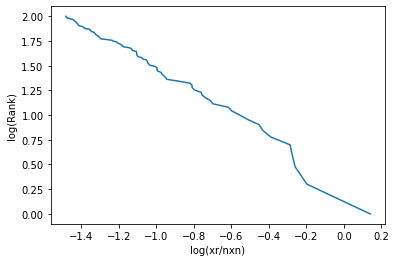

In [197]:
import matplotlib.pyplot as plt

nxn = df_freq.iloc[len(df_freq)-1]['Rank'] # getting the rank of the lowest frequency word.
df_freq['log(xr/nxn)'] = np.log10(df_freq['count']/nxn) # creating a column by dividing frequency of a word with nxn and taking log
df_freq['log(Rank)'] = np.log10(df_freq['Rank']) # creating a column with log of rank
plt.plot(df_freq['log(xr/nxn)'][:100],df_freq['log(Rank)'][:100]) # the plot should be approximately a straight line
plt.xlabel('log(xr/nxn)')
plt.ylabel('log(Rank)')

The plot for logarithm shows straight line which satisfies the equation:

$log(Rank) = \theta .log(\dfrac{x_r}{nx_n}) + \epsilon$  ($\theta \approx -1 $)

In [198]:
# cross-checking the value of theta using linear regression
from sklearn import linear_model
from patsy import dmatrices
Y, X = dmatrices('log(Rank) ~ 0 + Q("log(xr/nxn)")', df_freq,return_type="dataframe")
y = Y['log(Rank)'].values

model = linear_model.LinearRegression()
model.fit(X, y)
print('The slope of the line for equation log(rank) = theta * log(xr/nxn) is theta = ',model.coef_[0])

The slope of the line for equation log(rank) = theta * log(xr/nxn) is theta =  -1.6452690384495916


The theta value we got using linear regression is indicating a negative slope. This supports the Zipf's law

Text(0, 0.5, 'Rank')

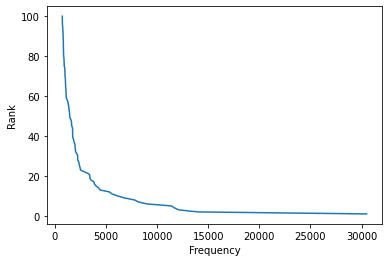

In [174]:
#visualizing hockey stick shape (Zipf's Law) for the top 100 words
import matplotlib.pyplot as plt

plt.plot(df_freq['count'][:100],df_freq['Rank'][:100])
plt.xlabel('Frequency')
plt.ylabel('Rank')

## Task B

### Removing stopwords and Lemmatization ###

In [116]:
# Run this if the following datasets are not downloaded

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sanjoshaju/nltk_data...


True

In [182]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def join_tokenized_string_list(x):
    return (" ").join(x)

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(text)]

# Stopword removal
df['Text_clean'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Lemmatization
df['Text_clean'] = df['Text_clean'].apply(lemmatize_text)
# Joining back tokenized string
df['Text_clean'] = df['Text_clean'].map(join_tokenized_string_list)

df.to_csv("comments_after_stopword_removal2.csv",index=False)
df[:10]

,Date,Text,Text_clean
0,March 2002,i personally think that with a few tweaks the ...,personally think tweak c320 could also sit top...
1,March 2002,i am debating a new volkswagen purchase and th...,debate new volkswagen purchase two top list pr...
2,March 2002,and no manual tranny that may not matter to yo...,manual tranny may matter certainly matter many...
3,March 2002,one beauty of bmw 3 series is that there are s...,one beauty bmw 3 series many model choose almo...
4,March 2002,good grief so you wait 9 months for the manual...,good grief wait 9 months manual even auto pref...
5,March 2002,ill give it a fair shot when the manual comes ...,ill give fair shoot manual come im flatout int...
6,March 2002,i understand its not about the speed i really ...,understand speed really dont care car wont 100...
7,March 2002,it sounds like you know why i wont even put it...,sound like know wont even put list let alone t...
8,March 2002,is there such a thing as an automaticonly true...,thing automaticonly true performance sedan boo...
9,March 2002,if i had to rank the entry lux performance sed...,rank entry lux performance sedans would choose...


### Replacing the car model mentions with brand names ###

In [183]:
df_replace = pd.read_csv('car models and brands (3).csv')
dict_model_brand = dict(zip(df_replace.Model, df_replace.Brand))

import re

def replace(match):
    return dict_model_brand[match.group(0)]

def replace_models_with_brands(text):
    text = re.sub('|'.join(r'\b%s\b' % re.escape(s) for s in dict_model_brand), replace, text)
    return text

df['Text_clean'] = df['Text_clean'].map(replace_models_with_brands)
df.to_csv("comments_after_stopwordRemoval_and_brandReplace.csv",index=False)
df[:10]

,Date,Text,Text_clean
0,March 2002,i personally think that with a few tweaks the ...,personally think tweak c320 could also sit top...
1,March 2002,i am debating a new volkswagen purchase and th...,debate new volkswagen purchase two top list pr...
2,March 2002,and no manual tranny that may not matter to yo...,manual tranny may matter certainly matter many...
3,March 2002,one beauty of bmw 3 series is that there are s...,one beauty bmw 3 series many model choose almo...
4,March 2002,good grief so you wait 9 months for the manual...,good grief wait 9 months manual even auto pref...
5,March 2002,ill give it a fair shot when the manual comes ...,ill give fair shoot manual come im flatout int...
6,March 2002,i understand its not about the speed i really ...,understand speed really dont care car wont 100...
7,March 2002,it sounds like you know why i wont even put it...,sound like know wont even put list let alone t...
8,March 2002,is there such a thing as an automaticonly true...,thing automaticonly true performance sedan boo...
9,March 2002,if i had to rank the entry lux performance sed...,rank entry lux performance sedans would choose...


### Get unique word count ###

In [184]:
# Calculate unique word frequency, keeping words unique for a single comment ie, is BMW appear twice in a comment for that comment frequency of BMW will be taken as 1
def unique_freq(Series):
    
    y = Series.map(lambda x: list(set(x.lstrip('"').rstrip('"').split())))

    wordlists_list = list(y)
    freq_dict = {}
    for i in range (len(wordlists_list)):
        for j in range(len(wordlists_list[i])):
            if wordlists_list[i][j] in freq_dict:
                freq_dict[wordlists_list[i][j]] = freq_dict[wordlists_list[i][j]] + 1
            else:
                freq_dict[wordlists_list[i][j]] = 1

    uniq_freq = pd.DataFrame(list(freq_dict.items()),columns = ['word','count']).set_index('word')
    return uniq_freq

# using above function to get unique word frequencies on Text_clean which has no stopwords and models replaced with
#brands. This result can be used to determine our top 10 brands.

df_unique_freq = unique_freq(df['Text_clean']).sort_values(by = 'count', ascending = False)
df_unique_freq.to_csv('Unique_Word_freq.csv')
df_unique_freq[:10]

,count
word,
car,2235
get,1648
bmw,1637
drive,1564
like,1462
cars,1424
think,1278
one,1270
dont,1221


### Top car brands found are:

In [185]:
list_of_brands = list(df_replace['Brand'].unique())
df_unique_freq[df_unique_freq.index.isin(list_of_brands)].head(10)

,count
word,
bmw,1637
acura,578
honda,560
audi,482
infiniti,445
toyota,365
nissan,309
subaru,214
mercedes,189


## Task C ##

### Lift values for top 10 brands ###

In [186]:
# This function takes a string, a list, dataframe from which a column with comments is specified and freq_series which has 
# the word unique frequencies and returns lift values of the string with all the values present in the list

def lift(string, string_list,dataf,column,freq_series):
    nrows = float(len(dataf))
    string_n = float(freq_series.loc[string])
    string_mask = dataf[column].str.contains(string)
    lift_list = []
    for items in string_list:
        if string == items:
            lift_list.append('NA')
        else:
            string_list_n = float(freq_series.loc[items])
            mel_count = float(dataf[string_mask][column].str.contains(items).sum())
            lift = (nrows * mel_count)/(string_n * string_list_n)
            lift_list.append(lift)
    
    return lift_list

brand_list = ['bmw','acura','honda','audi','infiniti','toyota','nissan','subaru','mercedes','volkswagen']

from time import sleep
lift_dict = {}
for i in range(len(brand_list)):
    lift_dict[brand_list[i]] = lift(brand_list[i], brand_list,df,'Text_clean',df_unique_freq)


brands_lift = pd.DataFrame.from_dict(lift_dict)
brands_lift.index = brand_list
brands_lift

,bmw,acura,honda,audi,infiniti,toyota,nissan,subaru,mercedes,volkswagen
bmw,NA,1.507441,1.187538,1.897105,1.964899,1.315872,1.185688,1.222889,1.824476,1.434442
acura,1.507441,NA,2.584775,2.478428,3.40951,1.648386,2.426849,2.200304,2.537486,1.882668
honda,1.187538,2.584775,NA,1.363071,1.41573,3.106849,3.174757,1.682243,1.857143,1.994318
audi,1.897105,2.478428,1.363071,NA,2.9372,1.317797,1.455102,2.198782,3.817427,4.337043
infiniti,1.964899,3.40951,1.41573,2.9372,NA,1.210159,2.932257,1.746508,2.93633,2.381001
toyota,1.315872,1.648386,3.106849,1.317797,1.210159,NA,3.530257,1.484061,1.972603,2.196762
nissan,1.185688,2.426849,3.174757,1.455102,2.932257,3.530257,NA,1.676799,1.812298,2.965578
subaru,1.222889,2.200304,1.682243,2.198782,1.746508,1.484061,1.676799,NA,1.619938,2.274851
mercedes,1.824476,2.537486,1.857143,3.817427,2.93633,1.972603,1.812298,1.619938,NA,4.393939
volkswagen,1.434442,1.882668,1.994318,4.337043,2.381001,2.196762,2.965578,2.274851,4.393939,NA


## Task D

### MDS Plot ###

In [187]:
# Take reciprocal of the values
def div(x):
    if x == 'NA':
        return 0
    else:
        return 1/x
df_scaled = brands_lift.applymap(div)

a = df_scaled.to_numpy()

# Applying MDS
from sklearn.manifold import MDS
X_scaled = (a - np.min(a))/np.ptp(a)

mds = MDS(2, random_state=0, dissimilarity='precomputed')
X_mds = mds.fit_transform(X_scaled)


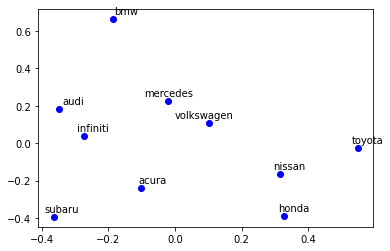

In [188]:
#  Plotting MDS
x= X_mds[:,0]
y= X_mds[:,1]

for i in range(len(x)):
    plt.scatter(x[i],y[i],c='blue')
    plt.annotate(
        brands_lift.index[i],
        xy = (x[i], y[i]), xytext = (25, 3),
        textcoords = 'offset points', ha = 'right', va = 'bottom')
plt.show()

## Task E

### Key Insights from MDS plot and lift values ###

Basis the lift values in Task C, we can see high values for the association between Volkswagen & Mercedes as well as Volkswagen & it's luxury sister brand, Audi - which showcases the affinity of Volkswagen to propel towards the luxury segments with some of its offerings like Volkswagen Phaeton (shown in the image below - 2004 version).

Additionally, there is a high association exhibited between Mercedes and Audi as well as Infiniti and Acura. This is evident as it's competing luxury brands and people are likely to talk about it a lot in the luxury segment. But, it's open to research and sentiment analysis might throw up more light in this area. 

From the MDS map obtained in task D, we can see that BMW is relatively far from all the brands which implies that people are not comparing BMW to other brands frequently. Also, we can see economy segment and luxury segment vehicles clustered together showing their associations.  

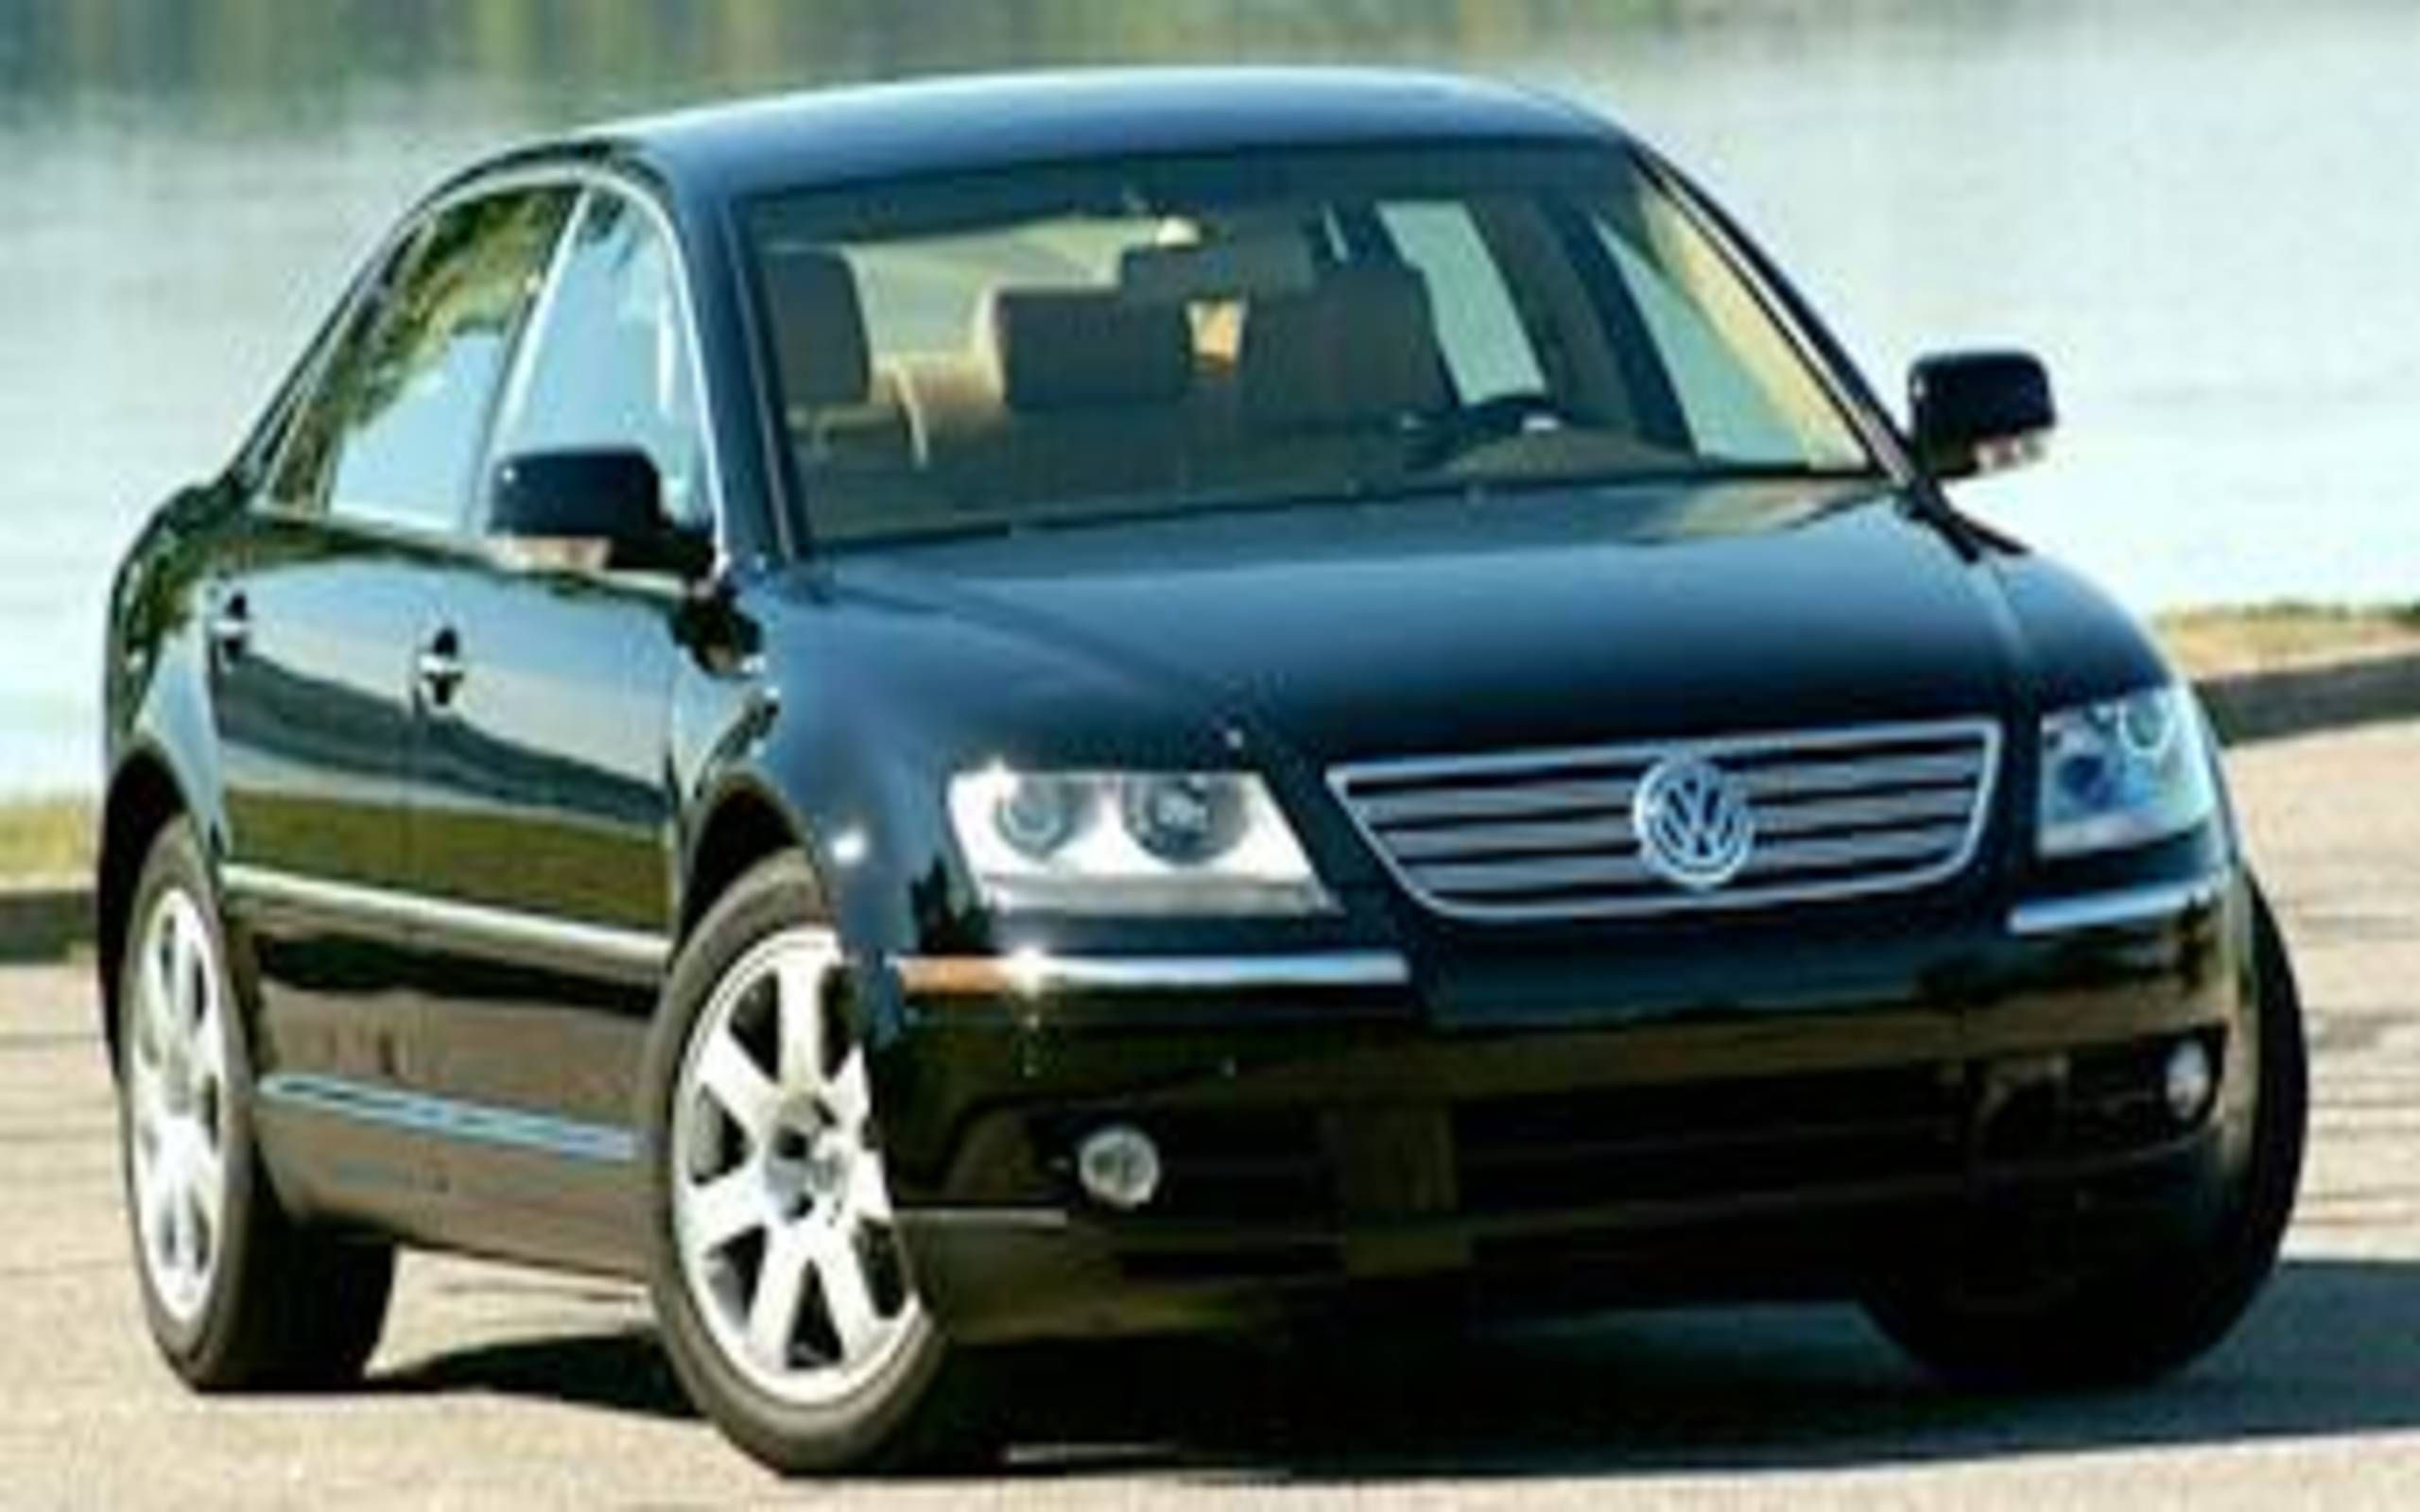

## Task F

Top 5 frequently mentioned attributes are:
1. drive
2. performance
3. price
4. handle
5. luxury

### Attributes lift values ###

In [190]:
attributes = ['drive','performance','price','handle','luxury','interior']
#,'pretty','torque','love','experience','reliability',\
#'fast','quality','mileage','acceleration','expensive','premium','horsepower','powerful']

att_dict = {}

for i in range(len(attributes)):
    att_dict[attributes[i]] = lift(attributes[i], brand_list,df,'Text_clean',df_unique_freq)

att_lift = pd.DataFrame.from_dict(att_dict)
att_lift.index = brand_list
att_lift

,drive,performance,price,handle,luxury,interior
bmw,1.360264,1.476361,1.566846,1.481981,1.436775,1.361633
acura,1.555500,1.462886,1.596967,1.595260,2.050750,1.756799
honda,1.496164,1.438573,1.575365,1.454707,1.716667,1.437346
audi,1.617939,1.464177,2.135349,1.857270,1.839557,2.826063
infiniti,1.426593,1.481187,1.725493,1.307602,1.761798,2.059244
toyota,1.297831,1.495738,1.745610,1.765882,2.505936,1.323146
nissan,1.105455,1.249695,1.268902,1.187811,1.510248,1.442714
subaru,1.566078,1.711132,1.526833,1.213127,3.140187,2.314634
mercedes,1.295823,1.197710,1.555916,1.515690,2.370370,1.310401
volkswagen,1.336608,1.324006,2.367025,1.424189,2.280303,1.547912


## Task G

### Insights from Attributes lift values ###

The most commonly mentioned attributes seem to be :-
* Drive
* Performance
* Price
* Handling
* Luxury
* Interior

From the lift values, we can observe a high association between Subaru and Luxury, which can be an anomaly and sentiment analysis can reveal further if it's a negative sentiment association between the two.

Additionally among the luxury car segments, we can observe a high association between Audi and Price, which could be because of Audi's strategy in having an entry-level luxury vehicle.

Additionally, it can be observed that BMW is associated the lowest with Luxury. It could possibly link to more common issues with BMW cars faced during that year.

## Task H

### Aspirational brands ###
#### Methodology:

- From the top 100 wordlist we selected the words and came up with bigrams which denote aspirational value. 
- Replaced such bigrams with a string 'aspiration_flag' and calculated lift values of that string with the top 10 brands

In [191]:
aspiration = ['love to', 'want to', 'dream of', 'hope to', 'like to', 'always wanted']

def replace_aspiration(x):
    for i in range(len(aspiration)):
        x = x.replace(aspiration[i],'aspiration_flag')       
    return x

df['Text_aspiration'] = df['Text'].map(replace_aspiration)

# Stopword removal
df['Text_aspiration'] = df['Text_aspiration'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# Lemmatization
df['Text_aspiration'] = df['Text_aspiration'].apply(lemmatize_text)
# Joining back tokenized string
df['Text_aspiration'] = df['Text_aspiration'].map(join_tokenized_string_list)
# Swapping models with brand
df['Text_aspiration'] = df['Text_aspiration'].map(replace_models_with_brands)

df

,Date,Text,Text_clean,Text_aspiration
0,March 2002,i personally think that with a few tweaks the ...,personally think tweak c320 could also sit top...,personally think tweak c320 could also sit top...
1,March 2002,i am debating a new volkswagen purchase and th...,debate new volkswagen purchase two top list pr...,debate new volkswagen purchase two top list pr...
2,March 2002,and no manual tranny that may not matter to yo...,manual tranny may matter certainly matter many...,manual tranny may matter certainly matter many...
3,March 2002,one beauty of bmw 3 series is that there are s...,one beauty bmw 3 series many model choose almo...,one beauty bmw 3 series many model choose almo...
4,March 2002,good grief so you wait 9 months for the manual...,good grief wait 9 months manual even auto pref...,good grief wait 9 months manual even auto pref...
...,...,...,...,...
5035,September 2006,did lexus ever say that they did and thats th...,lexus ever say thats rub many us dont time loo...,lexus ever say thats rub many us dont time loo...
5036,September 2006,if you look over in the is discussion here at ...,look discussion edmunds youll find post includ...,look discussion edmunds youll find post includ...
5037,September 2006,thats not the quote i was referring to by late...,thats quote refer late september last year kno...,thats quote refer late september last year kno...
5038,September 2006,since the 3er is the benchmark in this segment...,since bmw benchmark segment everyone else that...,since bmw benchmark segment everyone else that...


In [192]:
df_unique_freq_aspiration = unique_freq(df['Text_aspiration']).sort_values(by = 'count', ascending = False)
df_aspiration = pd.DataFrame(lift('aspiration_flag', brand_list,df,'Text_aspiration',df_unique_freq_aspiration), columns = ['aspiration lift'])
df_aspiration['brands'] = brand_list
df_aspiration.set_index('brands', inplace = True)
df_aspiration.T

brands,bmw,acura,honda,audi,infiniti,toyota,nissan,subaru,mercedes,volkswagen
aspiration lift,1.261035,1.405794,1.235294,1.412416,1.603878,1.603198,1.066057,1.231446,1.742919,1.559715


### Business Insights on Aspiration ###

The words used to describe aspiration of people towards the brands are: ‘Want to’, ‘Love to’, ‘Dream of’, ‘Hope to’, ‘Like to’ and ‘Always wanted’.

The most aspirational brand is “Mercedes”. Basis the lift values between the car brands and aspirational words, we can observe that people are associating Mercedes the most with these aspirational word segments. Also, "Subaru" was least associated with aspirational word segments which is evident from the fact that it focusses on economy segment and budget vehicles. And that's what we could see from the advertisements of both these brands below - the former focussing on luxury and the later focussing on economy (also evident in their respective advertisements below).

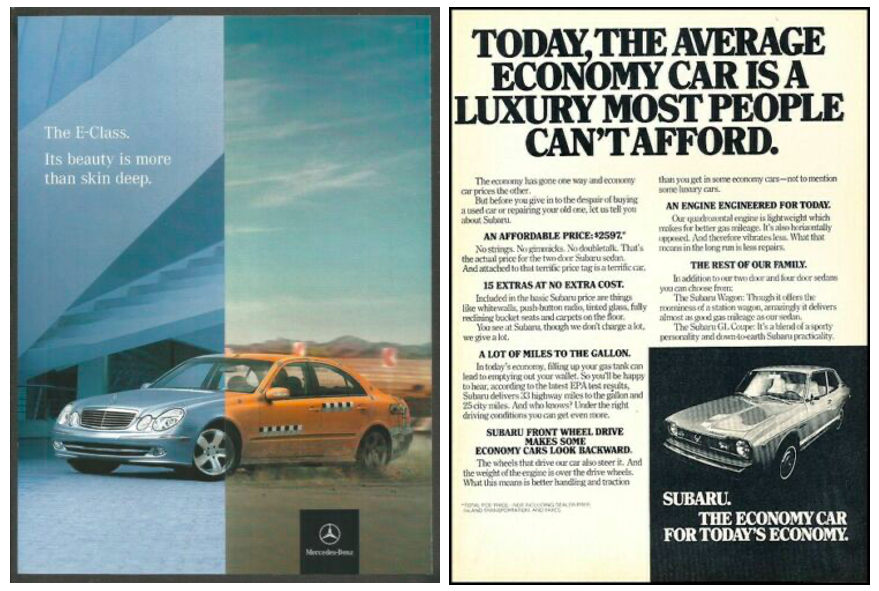